In [1]:
import cv2
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from scipy.cluster.vq import vq
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pickle


In [8]:

# define some constants
CURRENT_PATH = os.getcwd()
print(CURRENT_PATH)
#The data can be downloaded from src google-images-download, zip of 571M cannot be uploaded
#to the tencent platform with a restriction of 20M
IMG_PATH = os.path.join(CURRENT_PATH, 'data/images/')
IMG_LABELS_PATH = os.path.join(CURRENT_PATH, 'data/labels.csv')
IF_RANDOM_SPLIT = False
IF_RUN_CAL_ALL_DESCRIPTORS = True
IF_RUN_CAL_CODEBOOK = True
IF_TUNE_SVM = True
#IF_TRAIN_SVM = True
#IF_TUNE_KMEANS = False


C:\Users\sheaw\Desktop\imageprocessingprojectNN\svm


In [4]:

def train_test_idx(all_img_idx, train_percent, if_random_split=IF_RANDOM_SPLIT):
    """
    :param all_img_idx: list of image index integers
    :param train_percent:
    :return:
    """
    num_train = int(len(all_img_idx) * train_percent)
    if if_random_split:
        np.random.seed(1)
        train_idx = np.random.choice(all_img_idx, num_train, replace=False)
        train_idx.sort()
        test_idx = np.setdiff1d(all_img_idx, train_idx)
    else:
        train_idx = all_img_idx[0: num_train]
        test_idx = all_img_idx[num_train:]
    print('train_idx: {}'.format(len(train_idx)))
    print('test_idx: {}'.format(len(test_idx)))
    return train_idx, test_idx
#     if not if_random_split:
#         np.random.seed(1)
#     num_train = int(len(all_img_idx) * train_percent)
#     train_idx = np.random.choice(all_img_idx, num_train, replace=False)
#     train_idx.sort()
#     test_idx = np.setdiff1d(all_img_idx, train_idx)
#     print('train_idx: {}'.format(len(train_idx)))
#     print('test_idx: {}'.format(len(test_idx)))
#     return train_idx, test_idx

def cal_SIFT_all(train_idx):
    print('\nCalculating SIFT for all images:')
    start = datetime.datetime.now()
    descriptors_list = []
    for idx in train_idx:
        if idx % 100 == 0:
            print(idx)
        try:
            img_path = IMG_PATH + 'img_{}.jpg'.format(str(idx).zfill(3))
            image = cv2.imread(img_path, 0)

            sift = cv2.xfeatures2d.SIFT_create()
            kp, des = sift.detectAndCompute(image, None)

            # if des is not None:
            descriptors_list.append(des)  # descriptors = np.vstack((descriptors, des))
            # this_img_idx = np.array([idx + 1] * des.shape[0]).reshape((-1, 1))
            # img_idx_list.append(this_img_idx)  # img_idx = np.vstack((img_idx, this_img_idx))
        except cv2.error as e:
            print('Image {} error! '.format(idx), e)
    descriptors = np.concatenate(descriptors_list, axis=0)
    print('descriptors.shape: {}'.format(descriptors.shape))
    end = datetime.datetime.now()
    elapsed_time = end-start
    print('SIFT calculating elapsed time is: {}'.format(elapsed_time))
    print('Calculating SIFT for all images completed!')
    return descriptors

def cal_codebook(all_descriptors, kmeans_model, num_clusters=40):
    all_descriptors = all_descriptors.astype(np.float32)

    # Apply KMeans
    if kmeans_model == 'cv2':
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        # Set flags (Just to avoid line break in the code)
        flags = cv2.KMEANS_RANDOM_CENTERS
        print('\nApplying cv2.kmeans:')
        start = datetime.datetime.now()
        compactness, labels, centers = cv2.kmeans(all_descriptors, num_clusters, None, criteria, 10, flags)
        print(labels.shape)
        #print(labels)
        # print(centers)
        end = datetime.datetime.now()
        elapsed_time = end-start
        print('kmeans elapsed time is: {}'.format(elapsed_time))
        print('cv2.kmeans completed!')
        return centers

    elif kmeans_model == 'sklearn':
        print('\nApplying sklearn.KMeans:')
        start = datetime.datetime.now()
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_jobs=-2)
        kmeans.fit(all_descriptors)
        # print(kmeans.labels_)
        # print(kmeans.cluster_centers_)
        print('sse is {}'.format(kmeans.inertia_))
        end = datetime.datetime.now()
        print('time of running kmeans: {}'.format(end-start))
        print('skleran.KMeans completed!')
        print(type(kmeans.cluster_centers_))
        print(len(kmeans.cluster_centers_))
        print(kmeans.cluster_centers_.shape)
        return kmeans.cluster_centers_

def cal_img_features(img, codebook):
    """
    Calculate the features of a single image given the codebook(vocabulary) generated by clustering method (kmeans), each column is the center of the cluster.
    :param img:
    :param codebook:
    :return:
    """
    features = np.zeros((1, codebook.shape[1]))
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    code, _ = vq(des, codebook)
    for i in code:
        features[0, i] += 1
    return(features)

def cal_img_features_all(img_idx, codebook):
    print('\nStart calculating all image features:')
    start = datetime.datetime.now()
    features_all_list = []
    for idx in img_idx:
        img_path = IMG_PATH + 'img_{}.jpg'.format(str(idx).zfill(3))
        image = cv2.imread(img_path, 0)
        this_features = cal_img_features(image, codebook)
        features_all_list.append(this_features)
    features_all = np.concatenate(features_all_list, axis=0)
    print('features all shape is: {}'.format(features_all.shape))
    end = datetime.datetime.now()
    elapsed_time = end-start
    print('All image features calculating elapsed time is: {}'.format(elapsed_time))
    print('Calculating all image features completed!')
    return features_all

def get_df_labels(img_idx):
    # df_labels = pd.read_csv(IMG_LABELS_PATH)
    # df_labels = np.array(df_labels.iloc[img_idx, 1]).reshape((-1,1))
    # return(df_labels)
    df_labels = pd.read_csv(IMG_LABELS_PATH)
    df_labels = df_labels[df_labels['Image'].isin(img_idx)]
    df_labels = np.array(df_labels.iloc[:, 1]).reshape((-1, 1))
    return df_labels

def get_processed_df(img_idx, codebook):
    """
    Get processed dataframe for modeling.
    :param img_idx: train中所有的照片的id
    :param codebook:
    :return:
    """
    features_all = cal_img_features_all(img_idx, codebook)
    df_labels = get_df_labels(img_idx)

    print('df_labels.shape: {}'.format(df_labels.shape))
    print('features_all.shape: {}'.format(features_all.shape))
    df = np.concatenate((features_all, df_labels), axis=1)
    #print(df)
    return df

def train_svm(train_df, C=10, if_tune=IF_TUNE_SVM):
    print('\nStart training SVM:')
    start = datetime.datetime.now()
    if if_tune:
        print('Tuning SVM:')
        X_train = train_df[:, :-1]
        y_train = train_df[:, -1]

        classifier = svm.SVC(kernel='linear')
        svc_param_grid = {'C': [0.01, 0.1, 1, 10, 100, 200, 500]}
        gsSVM = GridSearchCV(classifier, param_grid=svc_param_grid, scoring="accuracy", n_jobs=4, verbose=1)
        classifier = gsSVM.fit(X_train, y_train)
        print("svm:")
        print(X_train.shape, y_train.shape)
        print('grid search best score is: {}'.format(gsSVM.best_score_))
        print('grid search best model is: {}'.format(gsSVM.best_estimator_))
        # SVM.fit(X, Y)
        end = datetime.datetime.now()
        elapsed_time = end-start
        print('Tuning SVM elapsed time is: {}'.format(elapsed_time))
        print('Tuning SVM completed!')
        return classifier
    else:
        X_train = train_df[:, :-1]
        y_train = train_df[:, -1]
        classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
        np.set_printoptions(precision=2)
        end = datetime.datetime.now()
        elapsed_time = end-start
        print('Training SVM elapsed time is: {}'.format(elapsed_time))
        return classifier


def predict_svm(model, test_df):
    print('\nStart predicting:')
    start = datetime.datetime.now()
    SVM = model
    X_test = test_df[:, :-1]
    y_test = test_df[:, -1]
    Y_pred = SVM.predict(X_test)
    
    final = pd.DataFrame({'Id': test_idx, 'TrueLabel':y_test, 'PredLabel': Y_pred})
    print(final['PredLabel'])
    final.to_csv('svm_1.csv', index=False)

    print(Y_pred.shape, y_test.shape, X_test.shape, test_df.shape, type(test_df))
    accuracy = sum(Y_pred == y_test)/len(y_test)
    print('accuracy is: {}'.format(accuracy))
    end = datetime.datetime.now()
    elapsed_time = end - start
    print('Predicting elapsed time is: {}'.format(elapsed_time))
    print('Predicting completed!')
    return accuracy


In [5]:
class_names = ['forceps1', 'scissors1', 'scissors2', 'tweezers']
all_img_idx = list(pd.read_csv(IMG_LABELS_PATH)['Image'])[:520]

# Choose train and test dataset randomly or not.
train_idx, test_idx = train_test_idx(all_img_idx, 0.6)




train_idx: 312
test_idx: 208


In [6]:
train_idx


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [7]:
test_idx

[313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479

In [9]:
# Calculate all the descriptors from train data using SIFT.
if IF_RUN_CAL_ALL_DESCRIPTORS:
    all_descriptors = cal_SIFT_all(train_idx)


Calculating SIFT for all images:
100
200
300
descriptors.shape: (1032200, 128)
SIFT calculating elapsed time is: 0:12:13.675793
Calculating SIFT for all images completed!


In [10]:
# Applying sklearn.cluster.KMeans to all features.
if IF_RUN_CAL_CODEBOOK:
    codebook = cal_codebook(all_descriptors, 'sklearn', 40)
    with open('./output/codebook', 'wb') as f:
        pickle.dump(codebook, f)
else:
    with open('./output/codebook', 'rb') as f:
        codebook = pickle.load(f)


Applying sklearn.KMeans:


c:\users\sheaw\appdata\local\programs\python\python36\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


sse is 62236258304.0
time of running kmeans: 0:13:00.615414
skleran.KMeans completed!
<class 'numpy.ndarray'>
40
(40, 128)


In [11]:
# Respectively calculate features for train and test images.
train_df = get_processed_df(train_idx, codebook)
test_df = get_processed_df(test_idx, codebook)


Start calculating all image features:
features all shape is: (312, 128)
All image features calculating elapsed time is: 0:11:43.717742
Calculating all image features completed!
df_labels.shape: (312, 1)
features_all.shape: (312, 128)

Start calculating all image features:
features all shape is: (208, 128)
All image features calculating elapsed time is: 0:08:00.570650
Calculating all image features completed!
df_labels.shape: (208, 1)
features_all.shape: (208, 128)


In [12]:
# Train svm classifier.
classifier = train_svm(train_df)
np.set_printoptions(precision=2)


Start training SVM:
Tuning SVM:
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 68.4min finished


svm:
(312, 128) (312,)
grid search best score is: 0.6410650281618023
grid search best model is: SVC(C=10, kernel='linear')
Tuning SVM elapsed time is: 1:08:45.964468
Tuning SVM completed!


In [13]:
# Predict labels using the trained svm.
accuracy_score = predict_svm(classifier, test_df)
f = open('accuracy_score.txt','w')
f.writelines(str(accuracy_score))
f.close()


Start predicting:
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
203    3.0
204    3.0
205    3.0
206    3.0
207    3.0
Name: PredLabel, Length: 208, dtype: float64
(208,) (208,) (208, 128) (208, 129) <class 'numpy.ndarray'>
accuracy is: 0.8173076923076923
Predicting elapsed time is: 0:00:00.046875
Predicting completed!


Confusion matrix, without normalization
[[56  0  0  0]
 [ 0 37 18  1]
 [ 0 14 41  1]
 [ 0  2  2 36]]


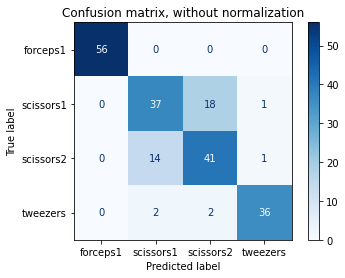

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.66 0.32 0.02]
 [0.   0.25 0.73 0.02]
 [0.   0.05 0.05 0.9 ]]


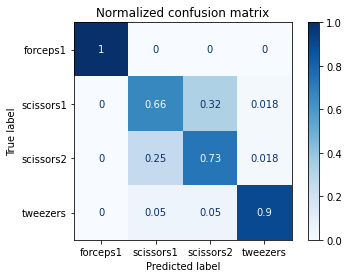

In [14]:
# Plot non-normalized confusion matrix
import matplotlib.pyplot as plt
%matplotlib inline
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, test_df[:, :-1], test_df[:, -1],
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.savefig(title + ".jpg")
    plt.show()